# Lets combine all the dataframe together and visualize,  day - wise 

#Read and load filepaths

In [1]:
import os
import pandas as pd
from tqdm import tqdm


class AISDataLoader:
    """
    Handles efficient loading of multiple AIS CSV files into pandas DataFrames.
    Includes memory-safe chunk loading support.
    """

    def __init__(self, base_folder: str):
        self.base_folder = base_folder
        self.ais_dfs = {}

    def _generate_file_paths(self, days=range(1, 8)):
        """Generate AIS file paths for given days (default 01–07)."""
        csv_files = [
            os.path.join(
                self.base_folder, f"AIS_2020_01_{day:02d}", f"AIS_2020_01_{day:02d}.csv"
            )
            for day in days
        ]
        return csv_files

    def load_all(self, days=range(1, 9), use_chunks=False, chunk_size=500_000):
        """
        Load multiple AIS CSVs.
        - If `use_chunks=True`, reads in smaller pieces and concatenates.
        """
        csv_files = self._generate_file_paths(days)

        for file_path in tqdm(csv_files, desc="📂 Loading AIS CSVs"):
            name = os.path.basename(file_path).replace(".csv", "")

            try:
                if use_chunks:
                    chunks = []
                    for chunk in pd.read_csv(
                        file_path, chunksize=chunk_size, low_memory=False
                    ):
                        chunks.append(chunk)
                    df = pd.concat(chunks, ignore_index=True)
                    del chunks
                else:
                    df = pd.read_csv(file_path, low_memory=False)

                self.ais_dfs[name] = df
                print(f"✅ Loaded {name}: {len(df):,} rows")

            except Exception as e:
                print(f"❌ Error loading {file_path}: {e}")

        return self.ais_dfs


class AISProcessor:
    """
    Handles cleaning and filtering AIS DataFrames.
    """

    def __init__(self, ais_dfs: dict):
        self.ais_dfs = ais_dfs

    @staticmethod
    def convert_datetime(df: pd.DataFrame) -> pd.DataFrame:
        """Convert BaseDateTime to pandas datetime safely."""
        df["BaseDateTime"] = pd.to_datetime(
            df["BaseDateTime"], format="%Y-%m-%dT%H:%M:%S", errors="coerce"
        )
        return df

    def filter_by_points(self, min_points: int = 50):
        """
        Remove MMSIs with fewer than `min_points` AIS records.
        """
        updated = {}

        for name, df in tqdm(self.ais_dfs.items(), desc="🔍 Filtering datasets"):
            print(f"\nProcessing {name}...")
            original_size = len(df)

            # Convert datetime safely
            df = self.convert_datetime(df)

            # Count points per MMSI
            mmsi_counts = df["MMSI"].value_counts()
            valid_mmsis = mmsi_counts[mmsi_counts >= min_points].index

            # Filter valid MMSIs
            df_filtered = df[df["MMSI"].isin(valid_mmsis)].reset_index(drop=True)

            print(
                f"  Original: {original_size:,} → Filtered: {len(df_filtered):,} rows "
                f"(Removed {original_size - len(df_filtered):,})"
            )

            updated[name] = df_filtered

            # Free memory
            del df, df_filtered, mmsi_counts, valid_mmsis

        self.ais_dfs = updated
        return self.ais_dfs


class AISPipeline:
    """
    High-level orchestration class for the AIS workflow.
    """

    def __init__(
        self, base_folder: str, min_points: int = 50, use_chunks: bool = False
    ):
        self.base_folder = base_folder
        self.min_points = min_points
        self.use_chunks = use_chunks
        self.loader = AISDataLoader(base_folder)
        self.processor = None
        self.ais_dfs = {}

    def run(self):
        """Run the complete pipeline."""
        print("\n🚀 Starting AIS data processing pipeline...\n")

        # Step 1: Load
        ais_dfs = self.loader.load_all(use_chunks=self.use_chunks)
        print("\n✅ All CSVs loaded.\n")

        # Step 2: Process
        self.processor = AISProcessor(ais_dfs)
        filtered_dfs = self.processor.filter_by_points(self.min_points)

        # Store processed data
        self.ais_dfs = filtered_dfs
        print("\n🏁 Pipeline complete.\n")
        return self.ais_dfs


# Example usage:
if __name__ == "__main__":
    data_folder = r"D:\Maritime_Vessel_monitoring\csv_extracted_data"

    pipeline = AISPipeline(
        base_folder=data_folder,
        min_points=50,
        use_chunks=True,  # ✅ safer for large files
    )

    ais_data = pipeline.run()


🚀 Starting AIS data processing pipeline...



📂 Loading AIS CSVs:  12%|█▎        | 1/8 [00:03<00:21,  3.05s/it]

✅ Loaded AIS_2020_01_01: 1,048,575 rows


📂 Loading AIS CSVs:  25%|██▌       | 2/8 [00:05<00:14,  2.49s/it]

✅ Loaded AIS_2020_01_02: 1,048,575 rows


📂 Loading AIS CSVs:  38%|███▊      | 3/8 [00:16<00:33,  6.70s/it]

✅ Loaded AIS_2020_01_03: 7,118,203 rows


📂 Loading AIS CSVs:  50%|█████     | 4/8 [00:27<00:33,  8.30s/it]

✅ Loaded AIS_2020_01_04: 6,937,852 rows


📂 Loading AIS CSVs:  62%|██████▎   | 5/8 [00:37<00:26,  8.94s/it]

✅ Loaded AIS_2020_01_05: 6,815,545 rows


📂 Loading AIS CSVs:  75%|███████▌  | 6/8 [00:48<00:19,  9.55s/it]

✅ Loaded AIS_2020_01_06: 7,032,498 rows


📂 Loading AIS CSVs:  88%|████████▊ | 7/8 [00:59<00:10, 10.07s/it]

✅ Loaded AIS_2020_01_07: 6,808,529 rows


📂 Loading AIS CSVs: 100%|██████████| 8/8 [01:10<00:00,  8.80s/it]


✅ Loaded AIS_2020_01_08: 6,870,094 rows

✅ All CSVs loaded.



🔍 Filtering datasets:   0%|          | 0/8 [00:00<?, ?it/s]


Processing AIS_2020_01_01...


🔍 Filtering datasets:  12%|█▎        | 1/8 [00:00<00:02,  2.60it/s]

  Original: 1,048,575 → Filtered: 988,449 rows (Removed 60,126)

Processing AIS_2020_01_02...


🔍 Filtering datasets:  25%|██▌       | 2/8 [00:00<00:02,  2.73it/s]

  Original: 1,048,575 → Filtered: 996,508 rows (Removed 52,067)

Processing AIS_2020_01_03...


🔍 Filtering datasets:  38%|███▊      | 3/8 [00:04<00:08,  1.71s/it]

  Original: 7,118,203 → Filtered: 7,089,446 rows (Removed 28,757)

Processing AIS_2020_01_04...


🔍 Filtering datasets:  50%|█████     | 4/8 [00:07<00:09,  2.36s/it]

  Original: 6,937,852 → Filtered: 6,908,736 rows (Removed 29,116)

Processing AIS_2020_01_05...


🔍 Filtering datasets:  62%|██████▎   | 5/8 [00:10<00:08,  2.67s/it]

  Original: 6,815,545 → Filtered: 6,790,866 rows (Removed 24,679)

Processing AIS_2020_01_06...


🔍 Filtering datasets:  75%|███████▌  | 6/8 [00:14<00:05,  2.93s/it]

  Original: 7,032,498 → Filtered: 7,003,855 rows (Removed 28,643)

Processing AIS_2020_01_07...


🔍 Filtering datasets:  88%|████████▊ | 7/8 [00:17<00:03,  3.02s/it]

  Original: 6,808,529 → Filtered: 6,782,070 rows (Removed 26,459)

Processing AIS_2020_01_08...


🔍 Filtering datasets: 100%|██████████| 8/8 [00:20<00:00,  2.52s/it]

  Original: 6,870,094 → Filtered: 6,844,953 rows (Removed 25,141)

🏁 Pipeline complete.



In [3]:
ais_data["AIS_2020_01_01"]

NameError: name 'ais_data' is not defined

In [1]:
import pandas as pd
from tqdm import tqdm
import os

# Folder where all AIS CSVs are stored
data_folder = r"D:\Maritime_Vessel_monitoring\csv_extracted_data"

# Generate file paths for 01 → 07
csv_files = [
    os.path.join(data_folder, f"AIS_2020_01_{day:02d}", f"AIS_2020_01_{day:02d}.csv")
    for day in range(1, 8)
]

# Dictionary to store loaded pandas DataFrames
ais_dfs_pd = {}

# Load with tqdm for progress visualization
for file_path in tqdm(csv_files, desc="Loading AIS CSVs"):
    # Extract dataset name from path
    name = os.path.basename(file_path).replace(".csv", "")

    # Load CSV into pandas
    df = pd.read_csv(file_path)

    # Store in dictionary
    ais_dfs_pd[name] = df

Loading AIS CSVs: 100%|██████████| 7/7 [00:57<00:00,  8.21s/it]


In [5]:
ais_data["AIS_2020_01_01"]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,538008468,2020-01-01 00:00:00,38.25802,-76.29487,14.9,338.6,337,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
1,368120510,2020-01-01 00:00:00,27.58610,-82.75991,0.0,58.6,511,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
2,368063930,2020-01-01 00:00:00,40.71045,-73.97588,11.2,208.9,207,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
3,368106220,2020-01-01 00:00:00,38.53932,-90.25523,0.2,161.8,31,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
4,367336180,2020-01-01 00:00:00,56.02945,-132.68705,9.0,325.5,511,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988444,368108120,2020-01-01 04:13:51,35.25534,-90.09801,4.6,339.4,340,PORTER J. FURLONG,NaN,WDK9974,31.0,0.0,264.0,16.0,3.0,31.0,A
988445,367447530,2020-01-01 04:16:21,27.70220,-82.71770,0.1,154.3,511,SWEET MELISSA,NaN,WDF4063,37.0,NaN,14.0,4.0,NaN,NaN,B
988446,367379540,2020-01-01 04:17:15,29.83253,-91.17663,3.6,325.9,511,EMMANUEL,NaN,WDE6384,31.0,0.0,21.0,9.0,NaN,57.0,A
988447,366963050,2020-01-01 04:16:25,38.92215,-90.28195,4.7,271.8,511,DALE A HELLER,NaN,WDB8703,31.0,0.0,39.0,13.0,NaN,NaN,A


In [8]:
ais_data["AIS_2020_01_03"]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,368020640,2020-01-03 00:00:00,40.63936,-80.47423,0.0,360.0,511.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
1,367683579,2020-01-03 00:00:00,40.12194,-91.51325,0.0,112.2,511.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
2,368053210,2020-01-03 00:00:01,57.77782,-152.41355,0.0,307.9,224.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
3,316036089,2020-01-03 00:00:00,45.36721,-87.08709,13.3,236.0,235.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
4,368051230,2020-01-03 00:00:00,40.73179,-73.97286,0.1,65.7,352.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7089441,367391180,2020-01-03 23:37:17,13.46194,144.66520,0.1,282.2,52.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
7089442,367391180,2020-01-03 23:40:45,13.46194,144.66523,0.1,249.9,53.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
7089443,368160000,2020-01-03 23:50:34,13.44580,144.63101,0.1,26.0,304.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,A
7089444,367391180,2020-01-03 23:57:26,13.46195,144.66519,0.0,292.5,52.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A


In [9]:
ais_data["AIS_2020_01_03"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7089446 entries, 0 to 7089445
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   MMSI              int64         
 1   BaseDateTime      datetime64[ns]
 2   LAT               float64       
 3   LON               float64       
 4   SOG               float64       
 5   COG               float64       
 6   Heading           float64       
 7   VesselName        object        
 8   IMO               object        
 9   CallSign          object        
 10  VesselType        float64       
 11  Status            float64       
 12  Length            float64       
 13  Width             float64       
 14  Draft             float64       
 15  Cargo             float64       
 16  TransceiverClass  object        
dtypes: datetime64[ns](1), float64(11), int64(1), object(4)
memory usage: 919.5+ MB


In [5]:
# Define your conversion function
def ConvertBaseDateTime(df: pd.DataFrame):
    df["BaseDateTime"] = pd.to_datetime(
        df["BaseDateTime"],
        format="%Y-%m-%dT%H:%M:%S",  # AIS ISO-style datetime format
        errors="coerce",
    )
    return df


# List all your dataframes
dfs = [
    ais_dfs_pd["AIS_2020_01_01"],
    ais_dfs_pd["AIS_2020_01_02"],
    ais_dfs_pd["AIS_2020_01_03"],
    ais_dfs_pd["AIS_2020_01_04"],
    ais_dfs_pd["AIS_2020_01_05"],
    ais_dfs_pd["AIS_2020_01_06"],
    ais_dfs_pd["AIS_2020_01_07"],
]

# Apply conversion to each
for i, df in enumerate(dfs, start=1):
    dfs[i - 1] = ConvertBaseDateTime(df)
    print(f"✅ Converted BaseDateTime for AIS_2020_01_{i:02d}")

✅ Converted BaseDateTime for AIS_2020_01_01
✅ Converted BaseDateTime for AIS_2020_01_02
✅ Converted BaseDateTime for AIS_2020_01_03
✅ Converted BaseDateTime for AIS_2020_01_04
✅ Converted BaseDateTime for AIS_2020_01_05
✅ Converted BaseDateTime for AIS_2020_01_06
✅ Converted BaseDateTime for AIS_2020_01_07


In [6]:
ais_dfs_pd["AIS_2020_01_03"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7118203 entries, 0 to 7118202
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   MMSI              int64         
 1   BaseDateTime      datetime64[ns]
 2   LAT               float64       
 3   LON               float64       
 4   SOG               float64       
 5   COG               float64       
 6   Heading           float64       
 7   VesselName        object        
 8   IMO               object        
 9   CallSign          object        
 10  VesselType        float64       
 11  Status            float64       
 12  Length            float64       
 13  Width             float64       
 14  Draft             float64       
 15  Cargo             float64       
 16  TransceiverClass  object        
dtypes: datetime64[ns](1), float64(11), int64(1), object(4)
memory usage: 923.2+ MB


In [7]:
ais_dfs_pd

{'AIS_2020_01_01':               MMSI        BaseDateTime       LAT        LON   SOG    COG  \
 0        538008468 2020-01-01 00:00:00  38.25802  -76.29487  14.9  338.6   
 1        368120510 2020-01-01 00:00:00  27.58610  -82.75991   0.0   58.6   
 2        368063930 2020-01-01 00:00:00  40.71045  -73.97588  11.2  208.9   
 3        368106220 2020-01-01 00:00:00  38.53932  -90.25523   0.2  161.8   
 4        367336180 2020-01-01 00:00:00  56.02945 -132.68705   9.0  325.5   
 ...            ...                 ...       ...        ...   ...    ...   
 1048570  368108120 2020-01-01 04:13:51  35.25534  -90.09801   4.6  339.4   
 1048571  367447530 2020-01-01 04:16:21  27.70220  -82.71770   0.1  154.3   
 1048572  367379540 2020-01-01 04:17:15  29.83253  -91.17663   3.6  325.9   
 1048573  366963050 2020-01-01 04:16:25  38.92215  -90.28195   4.7  271.8   
 1048574  367543880 2020-01-01 04:13:56  40.11881  -79.86158   0.0  360.0   
 
          Heading         VesselName  IMO CallSign  Vess


📊 Processing summary for AIS_2020_01_01 ...
✅ Completed AIS_2020_01_01 | Vessels: 9369 (>= 50 points)

📊 Processing summary for AIS_2020_01_02 ...
✅ Completed AIS_2020_01_02 | Vessels: 9322 (>= 50 points)

📊 Processing summary for AIS_2020_01_03 ...
✅ Completed AIS_2020_01_03 | Vessels: 12572 (>= 50 points)

📊 Processing summary for AIS_2020_01_04 ...
✅ Completed AIS_2020_01_04 | Vessels: 12346 (>= 50 points)

📊 Processing summary for AIS_2020_01_05 ...
✅ Completed AIS_2020_01_05 | Vessels: 12094 (>= 50 points)

📊 Processing summary for AIS_2020_01_06 ...
✅ Completed AIS_2020_01_06 | Vessels: 12570 (>= 50 points)

📊 Processing summary for AIS_2020_01_07 ...
✅ Completed AIS_2020_01_07 | Vessels: 12544 (>= 50 points)

📊 Processing summary for AIS_2020_01_08 ...
✅ Completed AIS_2020_01_08 | Vessels: 12505 (>= 50 points)


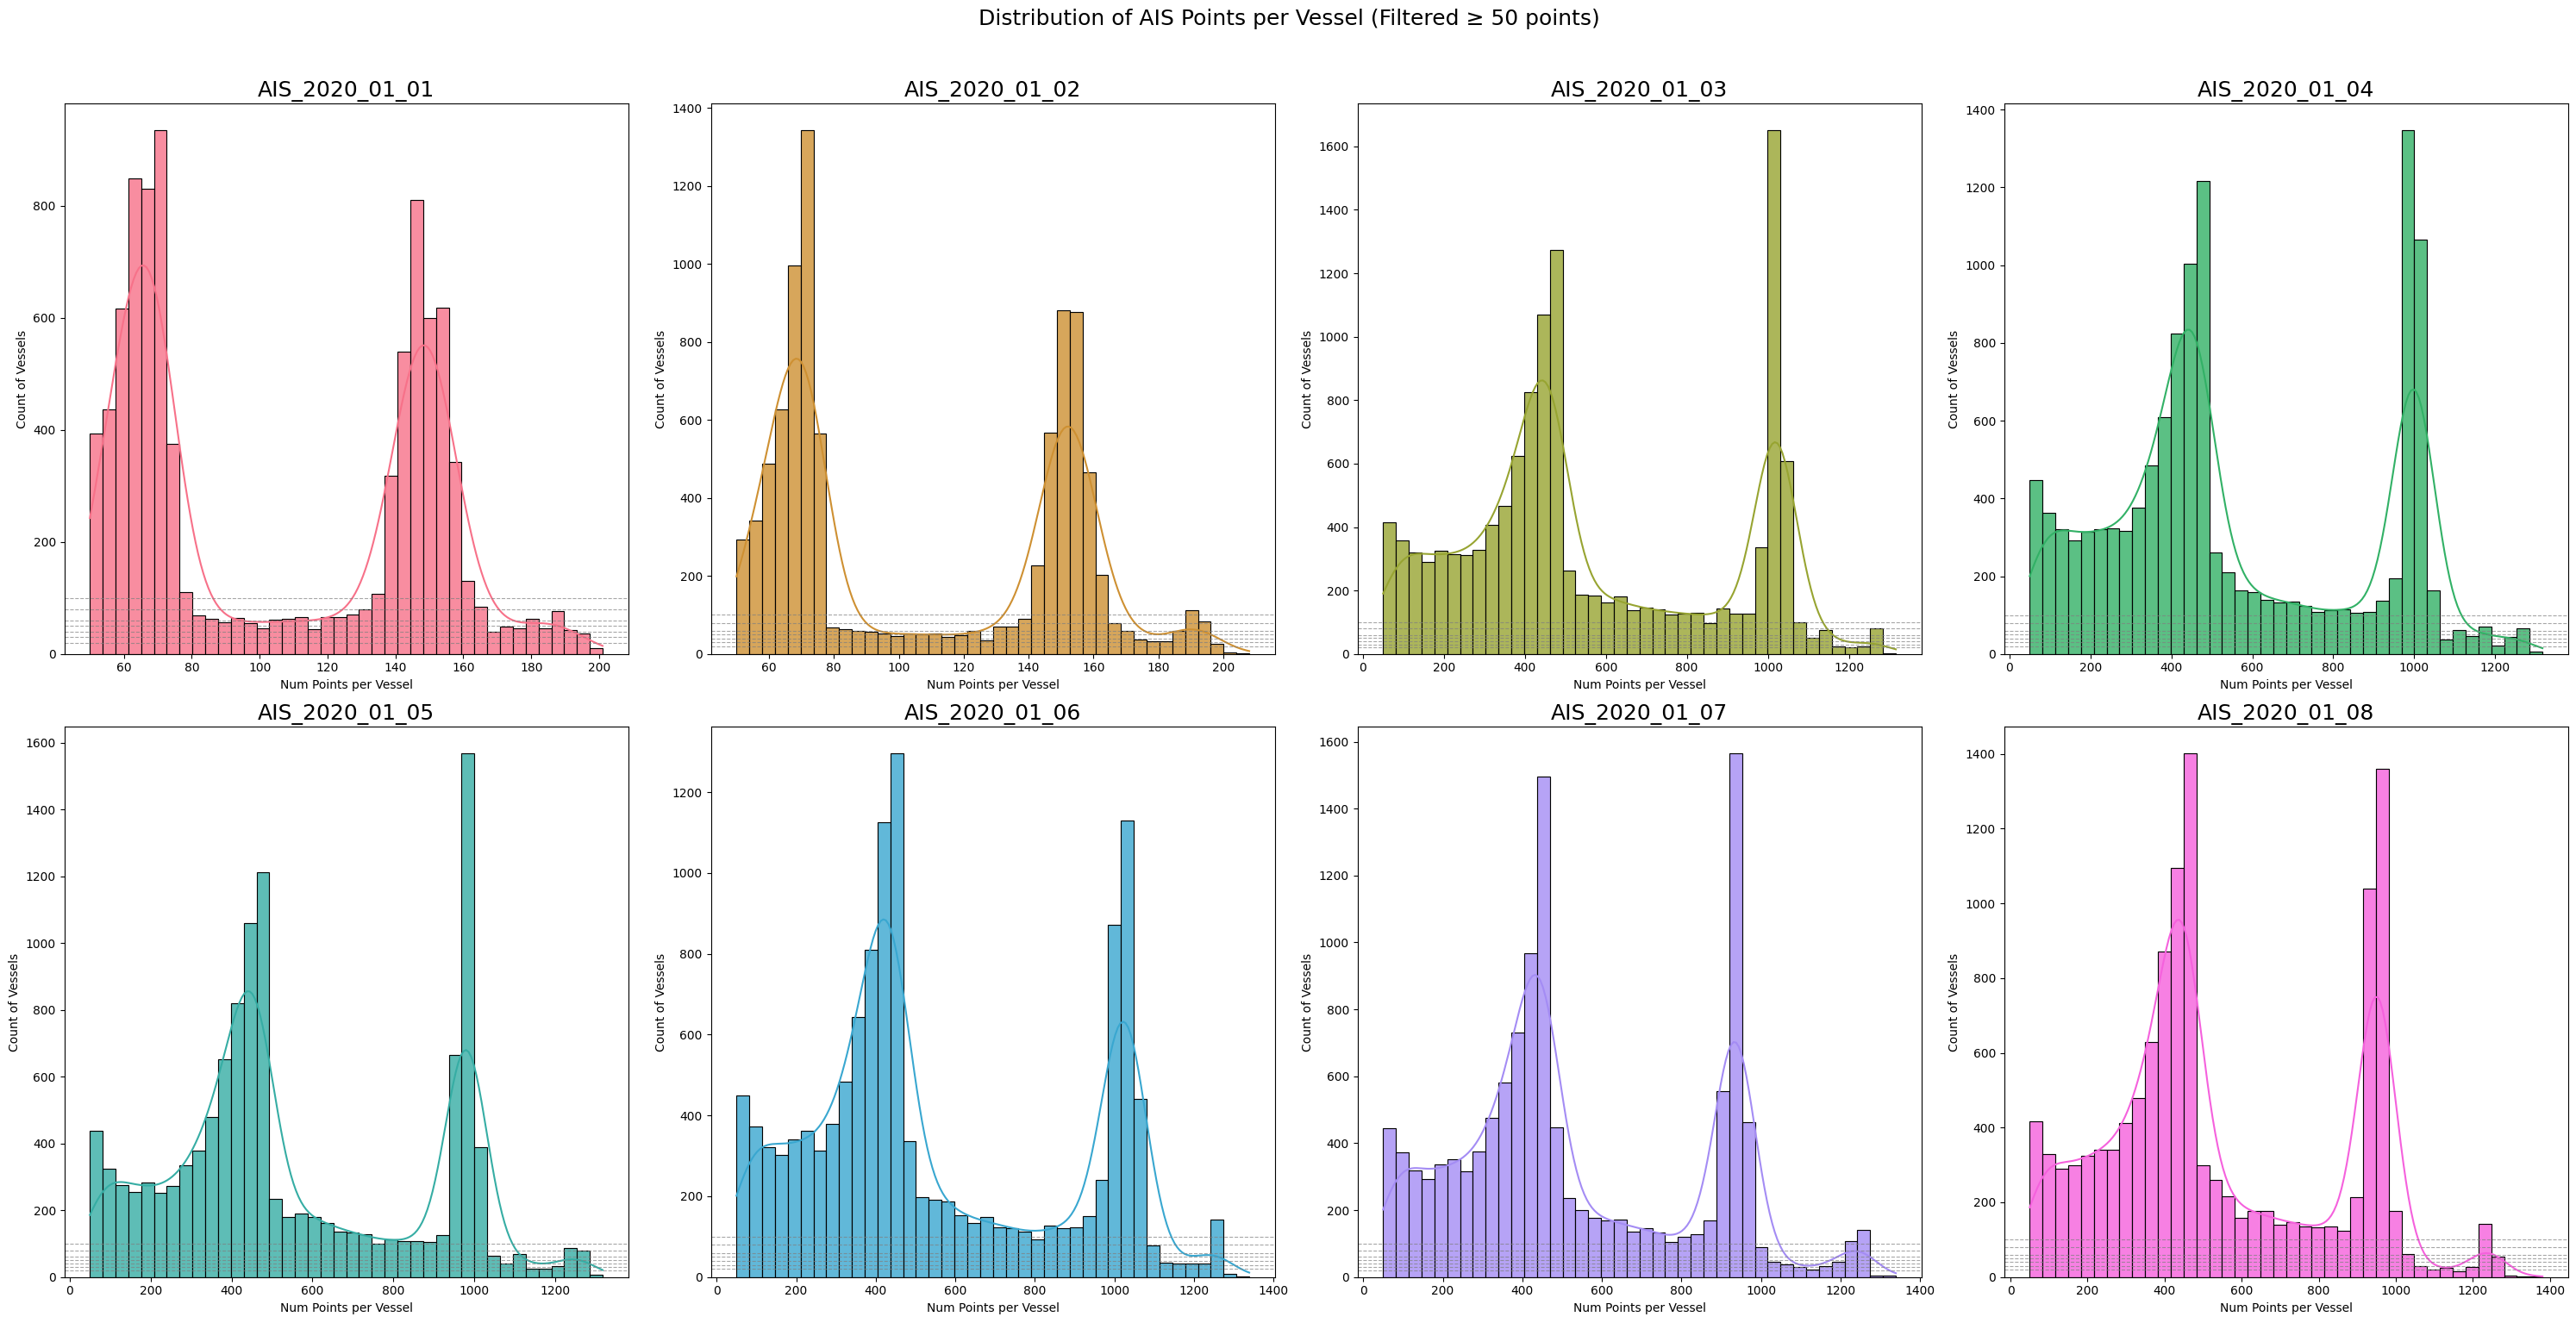

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def summarize_and_plot_ais_dataframes(
    ais_dfs: dict,
    reference_lines=(30, 50, 60, 80, 100),
    color_palette="husl",
    min_points=50,  # 🔹 Minimum points per vessel
):
    """
    Summarize AIS DataFrames, filter vessels with < min_points, and plot distribution.

    Args:
        ais_dfs (dict): {dataset_name: dataframe}
        reference_lines (tuple): Y-axis positions for dashed horizontal lines
        color_palette (str or list): Seaborn color palette name or list of colors
        min_points (int): Minimum number of points per MMSI to keep

    Returns:
        summaries (dict): {dataset_name: filtered summary_df}
    """

    summaries = {}
    num_datasets = len(ais_dfs)
    ncols = 4
    nrows = (num_datasets + ncols - 1) // ncols

    # 🎨 Define a color for each dataset
    colors = sns.color_palette(color_palette, num_datasets)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 15))
    axes = axes.flatten()

    for idx, (name, df) in enumerate(sorted(ais_dfs.items())):
        print(f"\n📊 Processing summary for {name} ...")

        # 🧹 Ensure datetime conversion
        if not pd.api.types.is_datetime64_any_dtype(df["BaseDateTime"]):
            df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors="coerce")

        # Sort and group by MMSI
        df_sorted = df.sort_values(by=["MMSI", "BaseDateTime"]).reset_index(drop=True)
        grouped = df_sorted.groupby("MMSI")["BaseDateTime"]

        # Compute summary stats
        summary_df = pd.DataFrame(
            {
                "first_timestamp": grouped.min(),
                "last_timestamp": grouped.max(),
                "num_points": grouped.count(),
            }
        ).reset_index()

        # 🔹 Filter vessels with fewer than min_points
        summary_df = summary_df[summary_df["num_points"] >= min_points]

        summaries[name] = summary_df

        # 🎨 Plot histogram
        ax = axes[idx]
        sns.histplot(
            summary_df["num_points"],
            bins=40,
            kde=True,
            color=colors[idx],
            ax=ax,
            alpha=0.8,
        )

        ax.set_title(f"{name}", fontsize=18)
        ax.set_xlabel("Num Points per Vessel")
        ax.set_ylabel("Count of Vessels")

        # ➖ Add dashed horizontal lines
        ymax = ax.get_ylim()[1]
        for y in reference_lines:
            if y < ymax:
                ax.axhline(y=y, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)

        print(
            f"✅ Completed {name} | Vessels: {len(summary_df)} (>= {min_points} points)"
        )

    # Hide unused subplots
    for ax in axes[num_datasets:]:
        ax.axis("off")

    plt.suptitle(
        f"Distribution of AIS Points per Vessel (Filtered ≥ {min_points} points)",
        fontsize=18,
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

    return summaries


# Usage: Filter vessels with <50 points automatically
summaries_filtered = summarize_and_plot_ais_dataframes(ais_dfs_pd, min_points=50)

In [10]:
ais_dfs_pd["AIS_2020_01_01"]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,538008468,2020-01-01 00:00:00,38.25802,-76.29487,14.9,338.6,337,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
1,368120510,2020-01-01 00:00:00,27.58610,-82.75991,0.0,58.6,511,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
2,368063930,2020-01-01 00:00:00,40.71045,-73.97588,11.2,208.9,207,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,A
3,368106220,2020-01-01 00:00:00,38.53932,-90.25523,0.2,161.8,31,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
4,367336180,2020-01-01 00:00:00,56.02945,-132.68705,9.0,325.5,511,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,368108120,2020-01-01 04:13:51,35.25534,-90.09801,4.6,339.4,340,PORTER J. FURLONG,NaN,WDK9974,31.0,0.0,264.0,16.0,3.0,31.0,A
1048571,367447530,2020-01-01 04:16:21,27.70220,-82.71770,0.1,154.3,511,SWEET MELISSA,NaN,WDF4063,37.0,NaN,14.0,4.0,NaN,NaN,B
1048572,367379540,2020-01-01 04:17:15,29.83253,-91.17663,3.6,325.9,511,EMMANUEL,NaN,WDE6384,31.0,0.0,21.0,9.0,NaN,57.0,A
1048573,366963050,2020-01-01 04:16:25,38.92215,-90.28195,4.7,271.8,511,DALE A HELLER,NaN,WDB8703,31.0,0.0,39.0,13.0,NaN,NaN,A


In [ ]:
import os
import folium
from folium.plugins import HeatMap

# ----------------------------
# CONFIGURATION
# ----------------------------
dataset_names = [
    "AIS_2020_01_01",
    "AIS_2020_01_02",
    "AIS_2020_01_03",
    "AIS_2020_01_04",
    "AIS_2020_01_05",
    "AIS_2020_01_06",
    "AIS_2020_01_07",
]

output_folder = "outputs/heatmaps_daywise"
os.makedirs(output_folder, exist_ok=True)

# Maximum points per dataset to avoid memory issues
max_points_per_day = 500_000  # adjust based on your system memory

# ----------------------------
# CREATE DAY-WISE HEATMAPS
# ----------------------------
for name in dataset_names:
    print(f"\n🌐 Creating heatmap for {name} ...")

    df = ais_dfs_pd[name]

    if df.empty:
        print(f"⚠️ {name} is empty. Skipping...")
        continue

    # Downsample if dataset is too large
    if len(df) > max_points_per_day:
        df_sampled = df.sample(max_points_per_day, random_state=42)
    else:
        df_sampled = df

    # Create folium map
    map_center = [df_sampled["LAT"].mean(), df_sampled["LON"].mean()]
    m = folium.Map(location=map_center, zoom_start=5, tiles="CartoDB positron")

    # Prepare heatmap data
    heat_data = list(zip(df_sampled["LAT"], df_sampled["LON"]))

    # Add HeatMap layer
    HeatMap(heat_data, radius=5, blur=10, max_zoom=10).add_to(m)

    # Save HTML
    output_path = os.path.join(output_folder, f"heatmap_positions_{name}.html")
    m.save(output_path)

    print(f"✅ Saved heatmap: {output_path}")


🌐 Creating heatmap for AIS_2020_01_01 ...
✅ Saved heatmap: outputs/heatmaps_daywise\heatmap_positions_AIS_2020_01_01.html

🌐 Creating heatmap for AIS_2020_01_02 ...
✅ Saved heatmap: outputs/heatmaps_daywise\heatmap_positions_AIS_2020_01_02.html

🌐 Creating heatmap for AIS_2020_01_03 ...
✅ Saved heatmap: outputs/heatmaps_daywise\heatmap_positions_AIS_2020_01_03.html

🌐 Creating heatmap for AIS_2020_01_04 ...
✅ Saved heatmap: outputs/heatmaps_daywise\heatmap_positions_AIS_2020_01_04.html

🌐 Creating heatmap for AIS_2020_01_05 ...
✅ Saved heatmap: outputs/heatmaps_daywise\heatmap_positions_AIS_2020_01_05.html

🌐 Creating heatmap for AIS_2020_01_06 ...
✅ Saved heatmap: outputs/heatmaps_daywise\heatmap_positions_AIS_2020_01_06.html

🌐 Creating heatmap for AIS_2020_01_07 ...
✅ Saved heatmap: outputs/heatmaps_daywise\heatmap_positions_AIS_2020_01_07.html


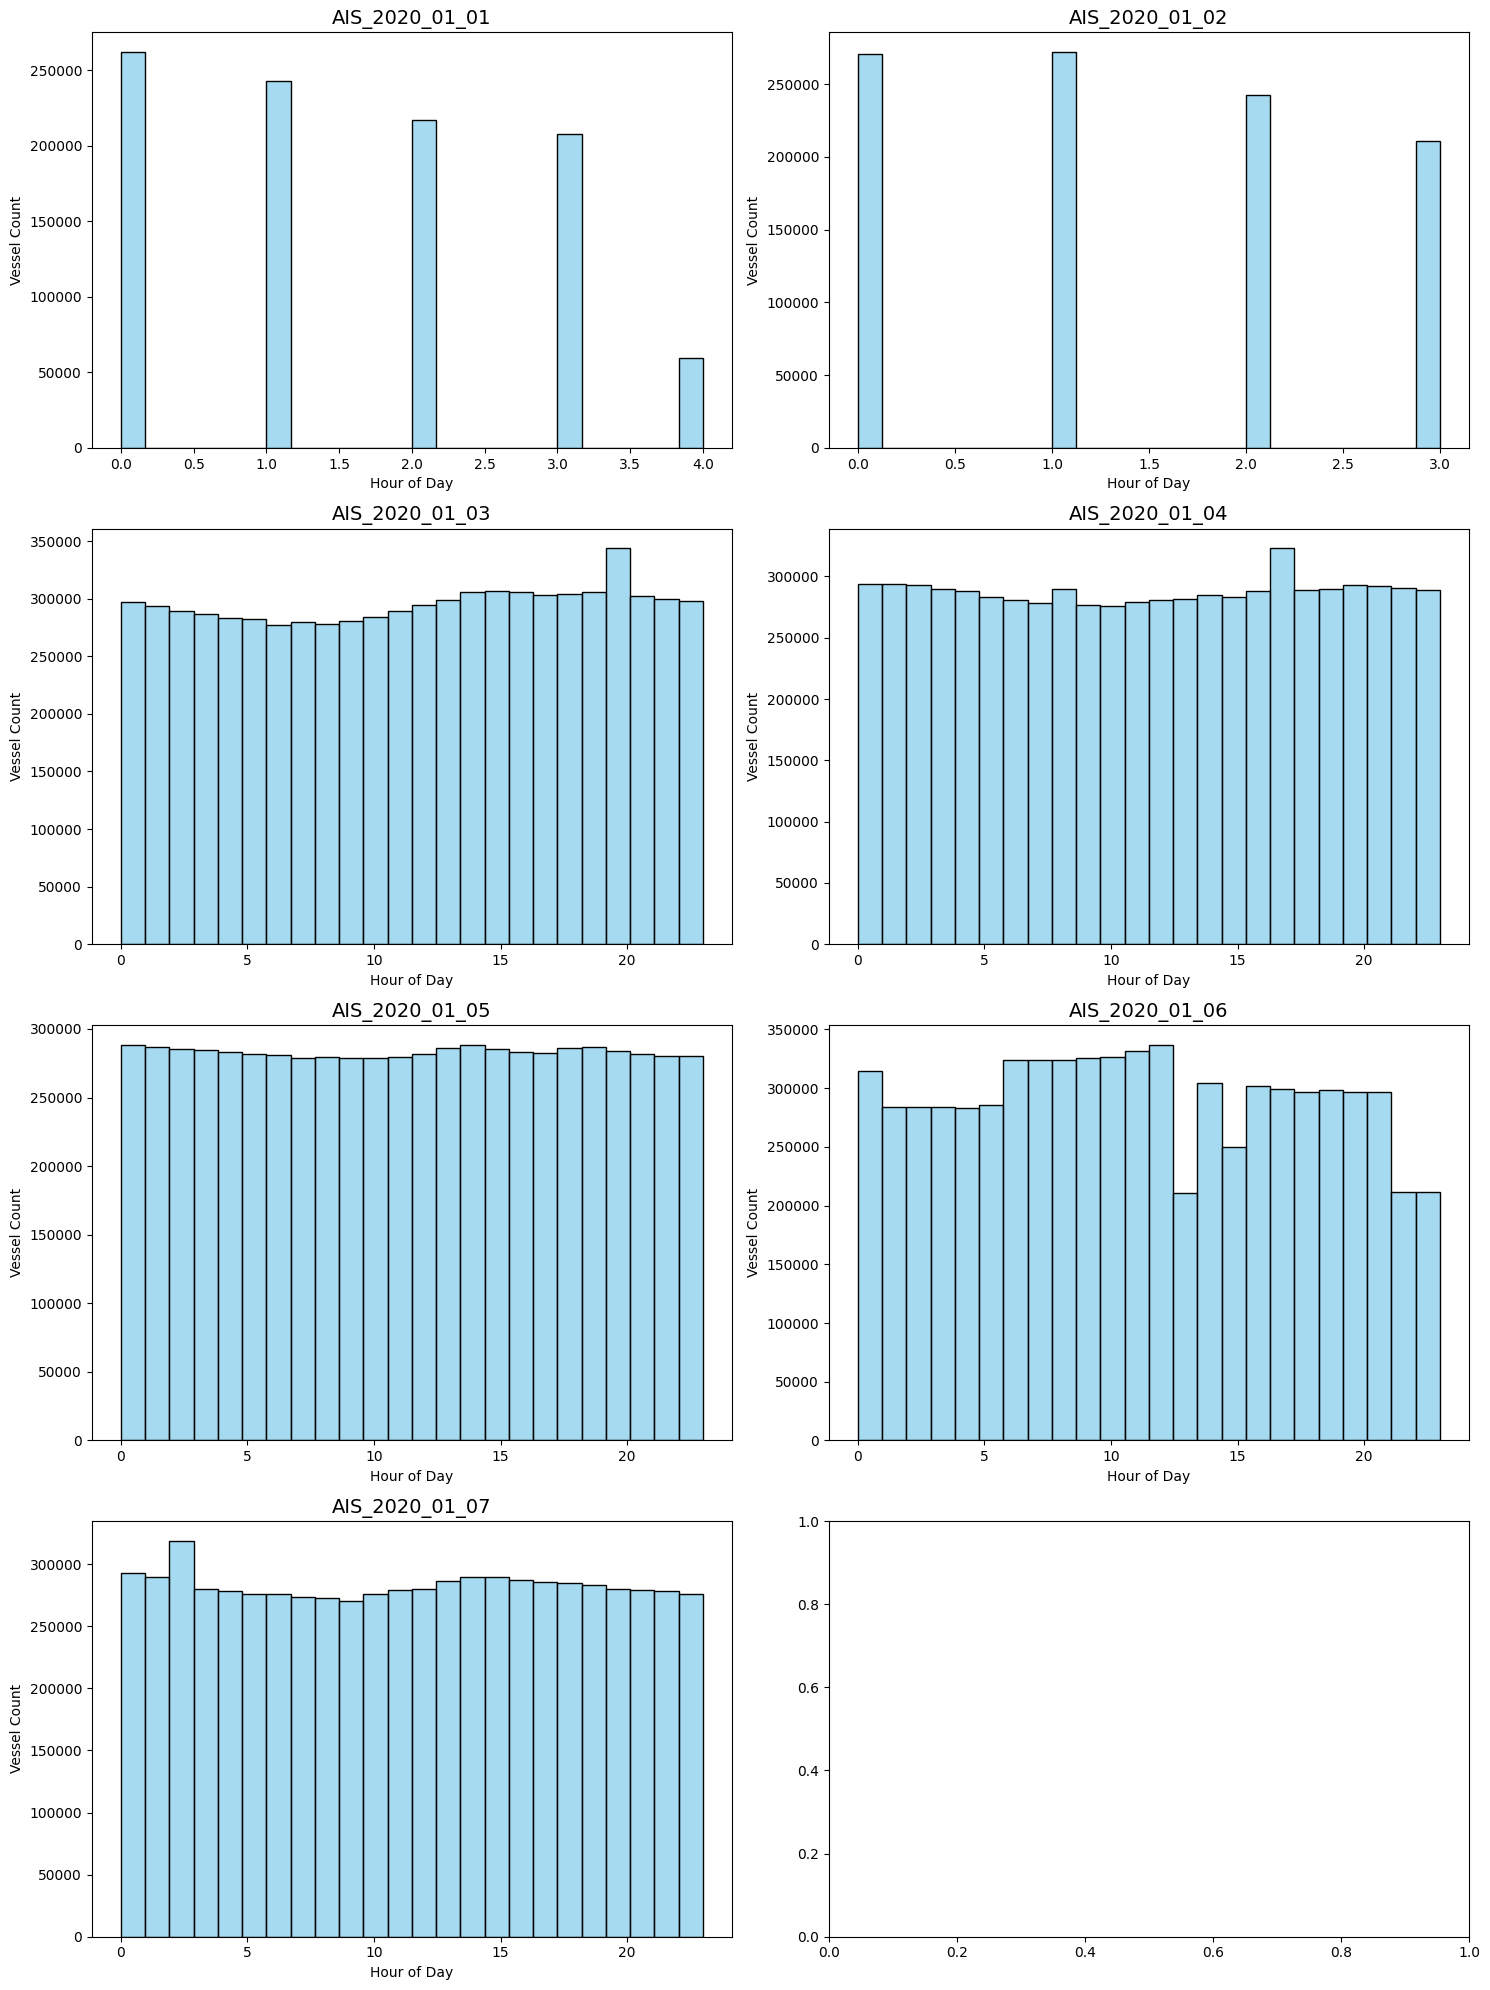

KeyboardInterrupt: 

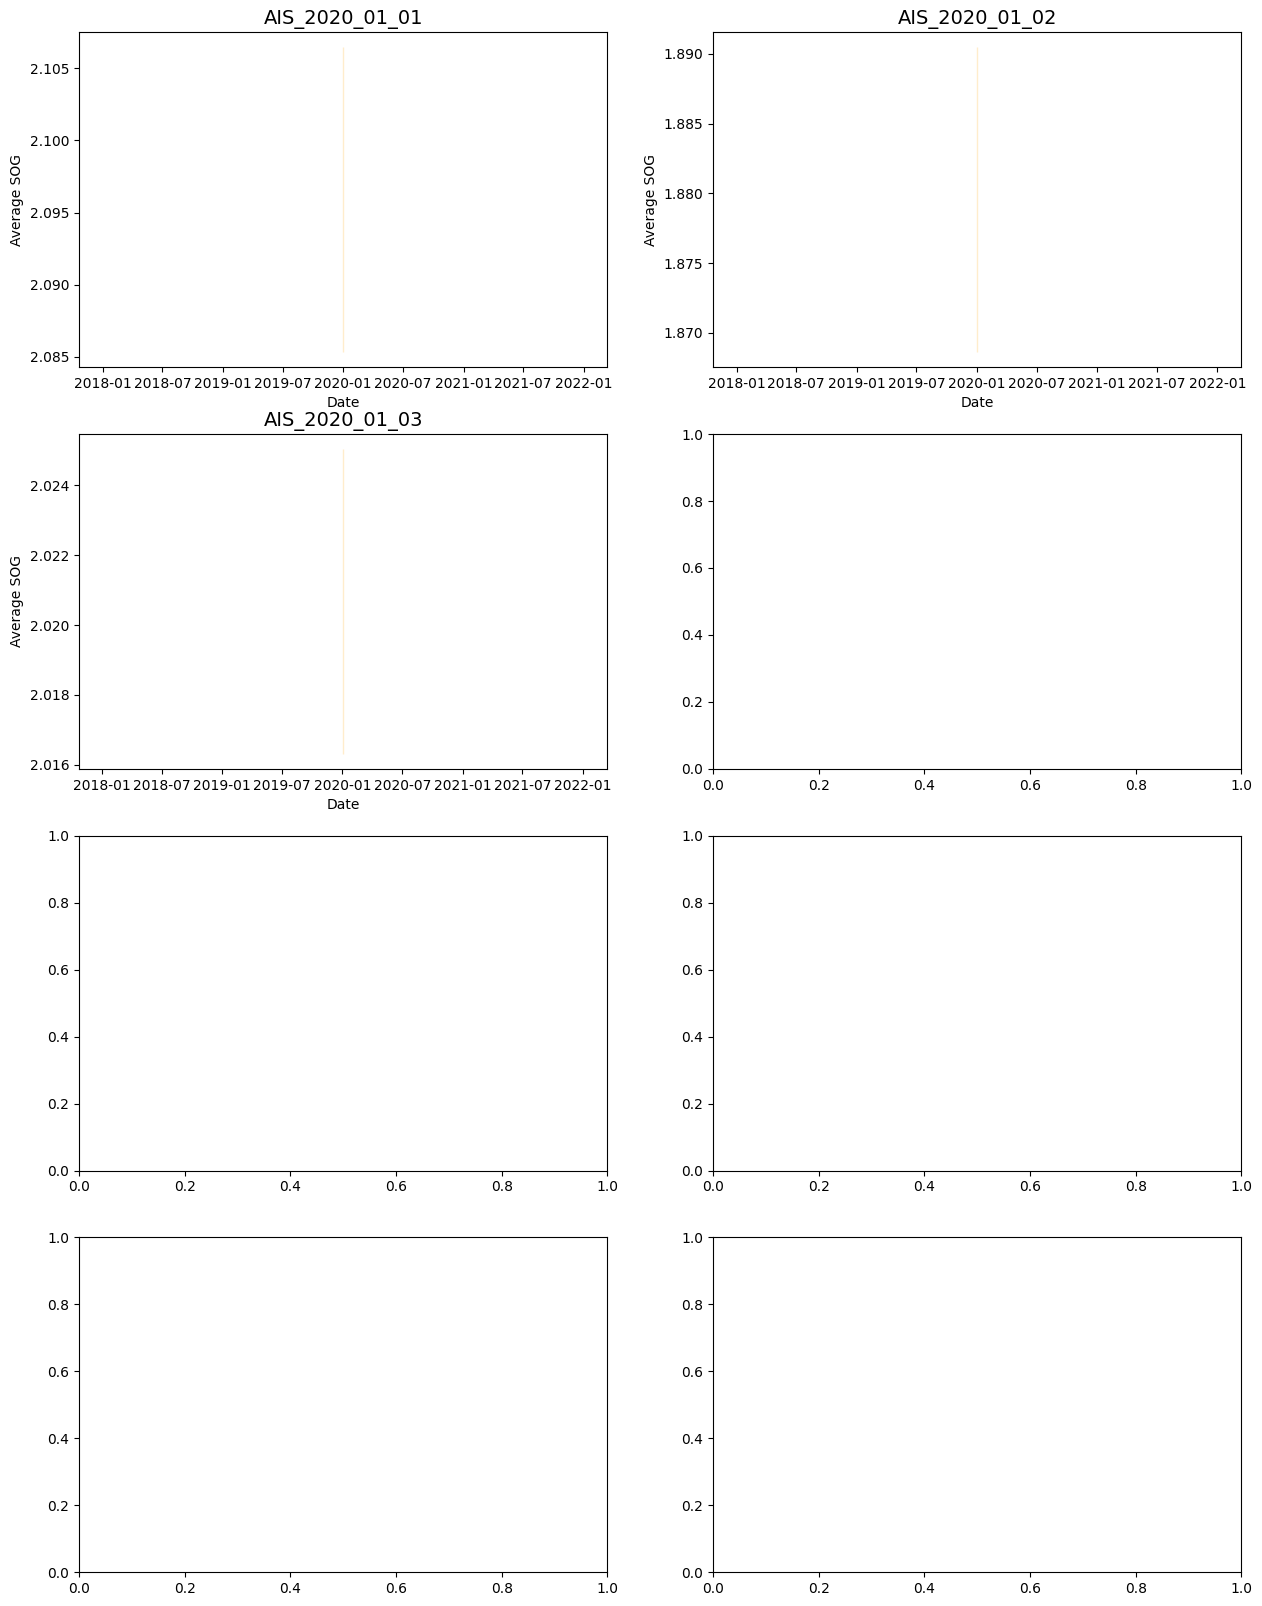

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_vessel_patterns(ais_dfs, dataset_names):
    """
    Plot vessel activity patterns for multiple AIS datasets:
    1. Histogram of vessel activity by hour of day
    2. Average vessel speed (SOG) over time
    """
    num_datasets = len(dataset_names)
    ncols = 2
    nrows = (num_datasets + ncols - 1) // ncols

    # Set up figure
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for idx, name in enumerate(dataset_names):
        df = ais_dfs[name]
        ax = axes[idx]

        # Ensure BaseDateTime is datetime
        if not pd.api.types.is_datetime64_any_dtype(df["BaseDateTime"]):
            df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors="coerce")

        # Create hour column
        df["hour"] = df["BaseDateTime"].dt.hour

        # Create date column
        df["date"] = df["BaseDateTime"].dt.date

        # Subplot title
        ax.set_title(f"{name}", fontsize=14)

        # Plot hourly activity histogram
        sns.histplot(df["hour"], bins=24, kde=False, color="skyblue", ax=ax)
        ax.set_xlabel("Hour of Day")
        ax.set_ylabel("Vessel Count")

    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Plot average SOG over time
    # -------------------------------
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for idx, name in enumerate(dataset_names):
        df = ais_dfs[name]
        ax = axes[idx]

        # Ensure BaseDateTime is datetime
        if not pd.api.types.is_datetime64_any_dtype(df["BaseDateTime"]):
            df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors="coerce")

        df["date"] = df["BaseDateTime"].dt.date

        # Plot mean SOG over date
        sns.lineplot(
            data=df, x="date", y="SOG", estimator="mean", ax=ax, color="orange"
        )
        ax.set_xlabel("Date")
        ax.set_ylabel("Average SOG")
        ax.set_title(f"{name}", fontsize=14)

    plt.tight_layout()
    plt.show()


dataset_names = [
    "AIS_2020_01_01",
    "AIS_2020_01_02",
    "AIS_2020_01_03",
    "AIS_2020_01_04",
    "AIS_2020_01_05",
    "AIS_2020_01_06",
    "AIS_2020_01_07",
]

plot_vessel_patterns(ais_data, dataset_names)

### Observations : We see that the data-points collected for the day of 2020-01-01 and 2020-01-02 have data for only between 00:00:00 AM to 4:00:00 AM , while the rest of the dataframe has significant more datapoints as compared .


📊 Vessel Stats for AIS_2020_01_01


C:\Users\amans\AppData\Local\Temp\ipykernel_25352\2851393782.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


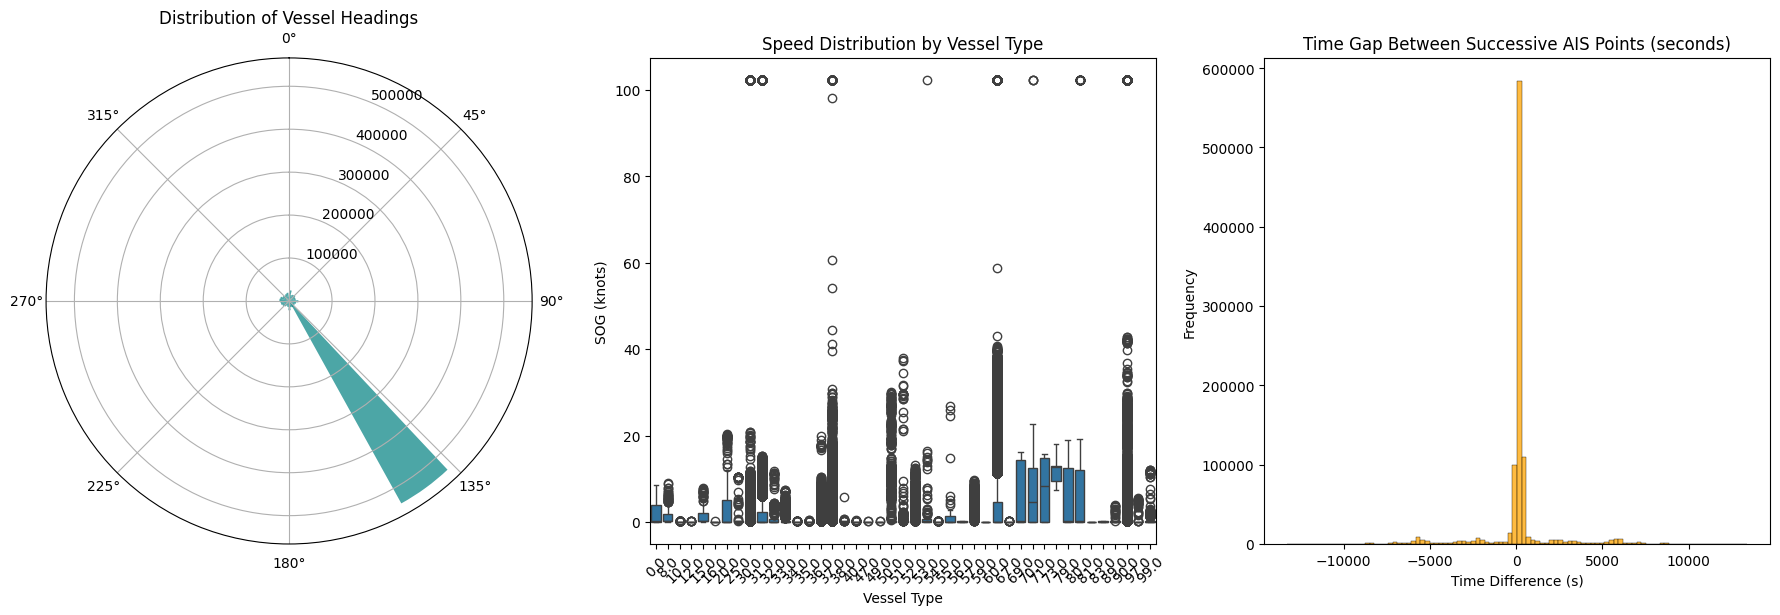


📊 Vessel Stats for AIS_2020_01_02


C:\Users\amans\AppData\Local\Temp\ipykernel_25352\2851393782.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


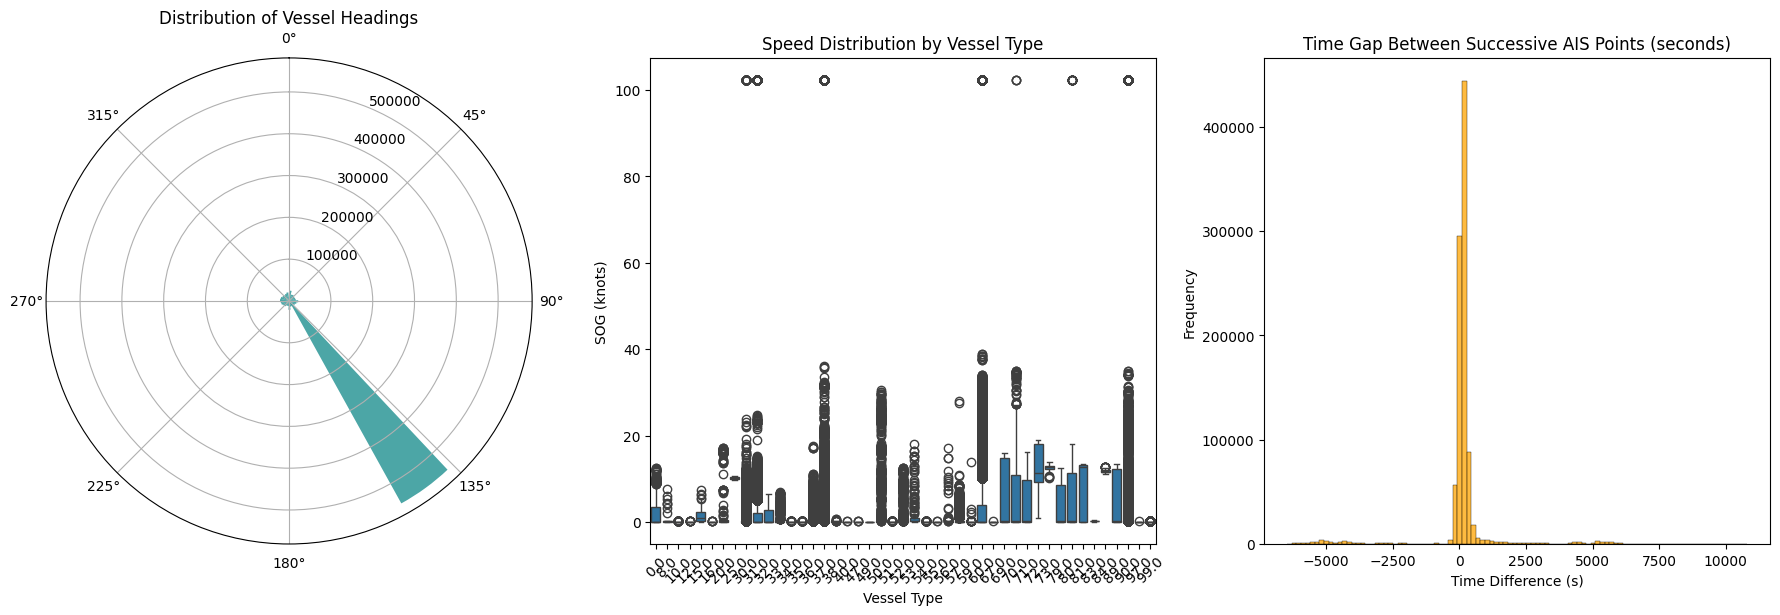


📊 Vessel Stats for AIS_2020_01_03


C:\Users\amans\AppData\Local\Temp\ipykernel_25352\2851393782.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


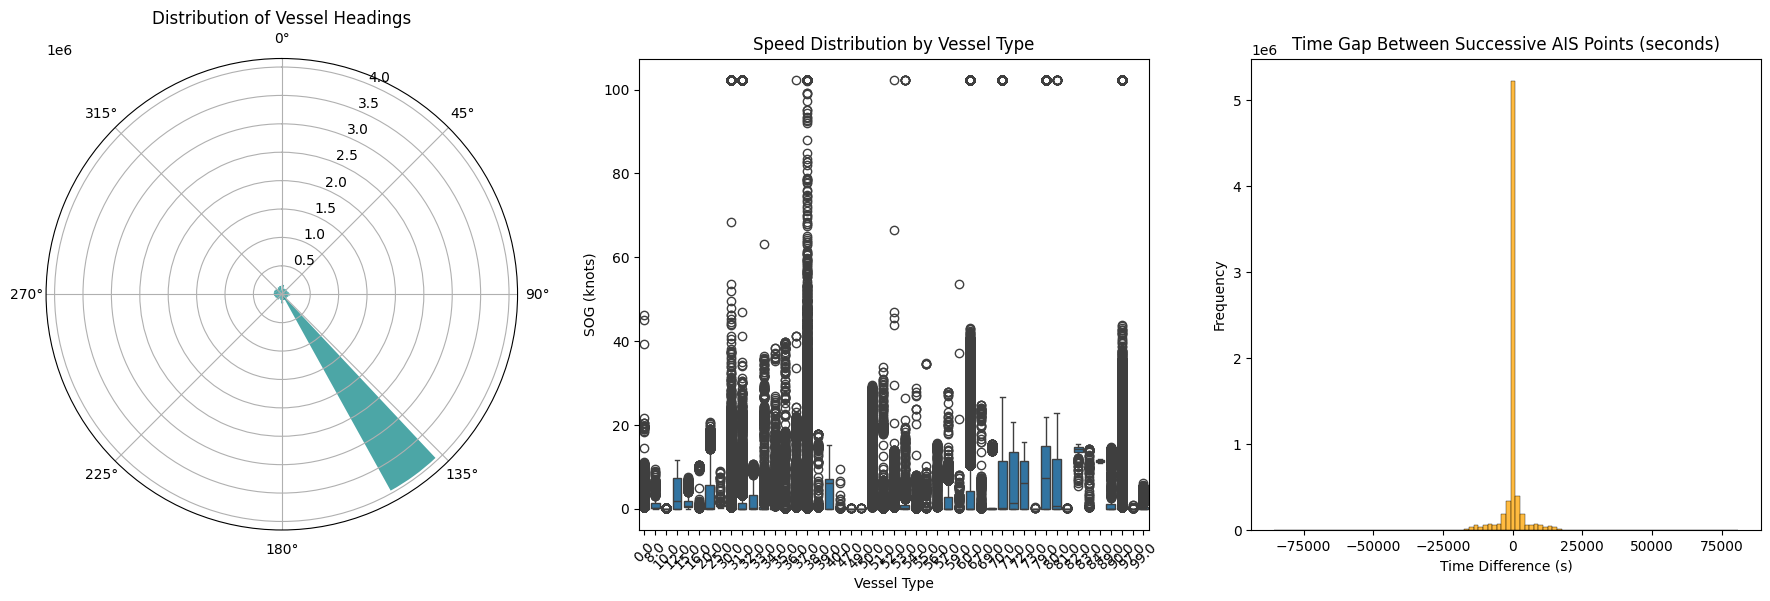


📊 Vessel Stats for AIS_2020_01_04


C:\Users\amans\AppData\Local\Temp\ipykernel_25352\2851393782.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


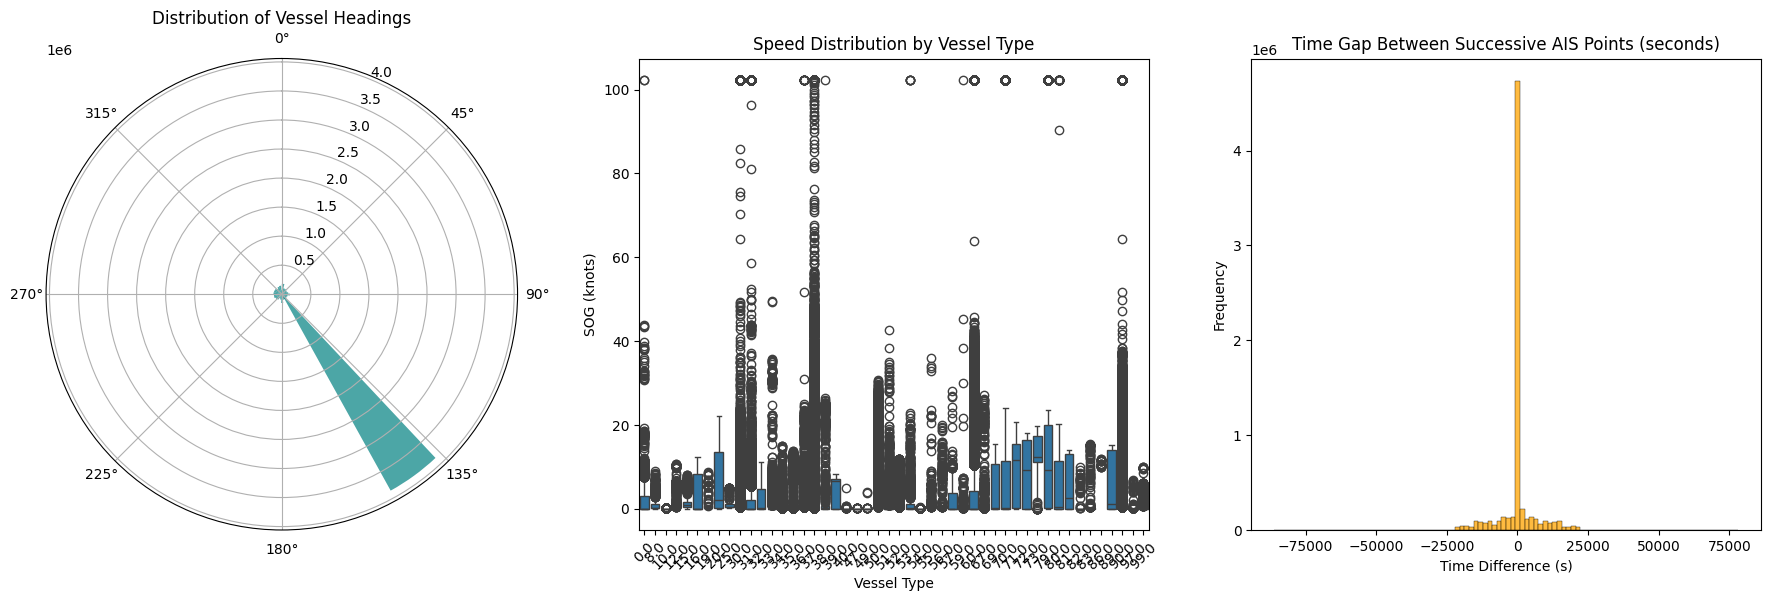


📊 Vessel Stats for AIS_2020_01_05


C:\Users\amans\AppData\Local\Temp\ipykernel_25352\2851393782.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


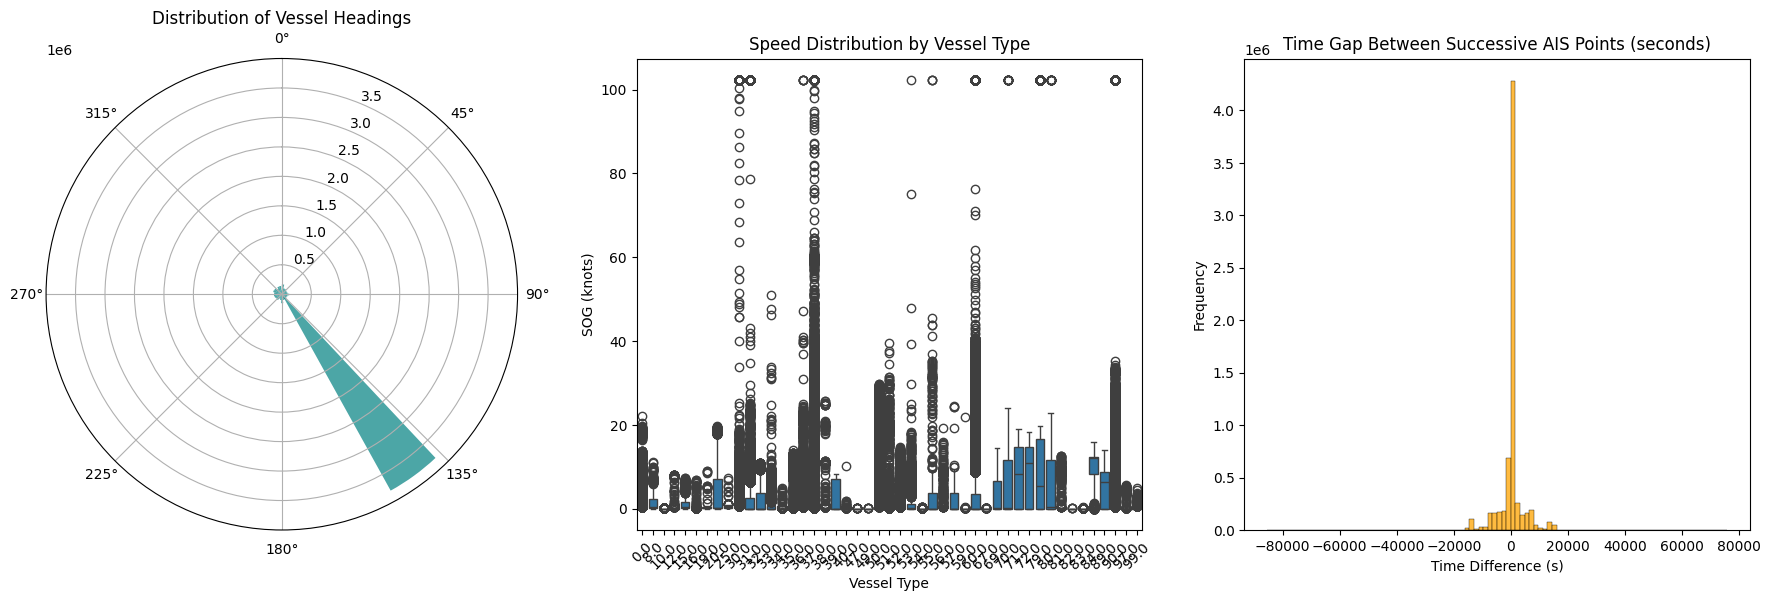


📊 Vessel Stats for AIS_2020_01_06


C:\Users\amans\AppData\Local\Temp\ipykernel_25352\2851393782.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


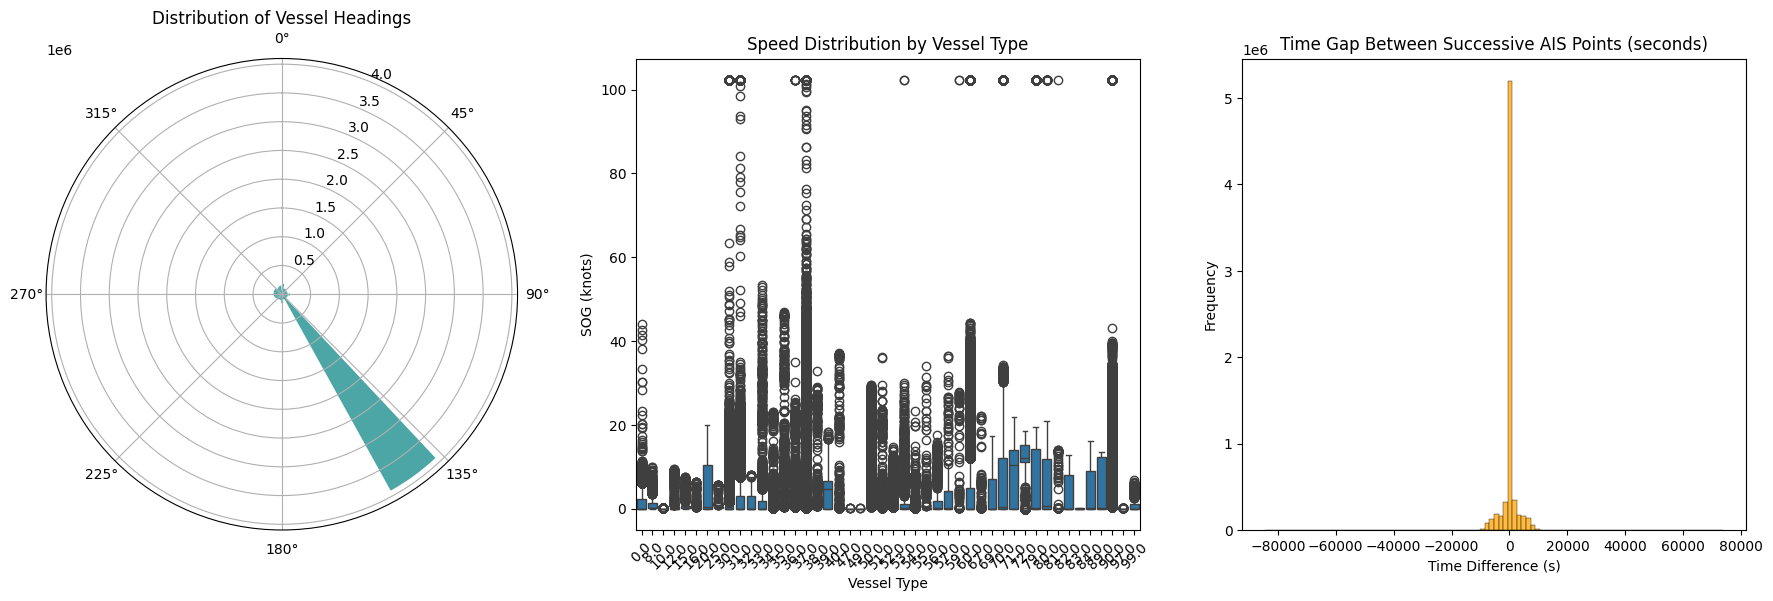


📊 Vessel Stats for AIS_2020_01_07


C:\Users\amans\AppData\Local\Temp\ipykernel_25352\2851393782.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


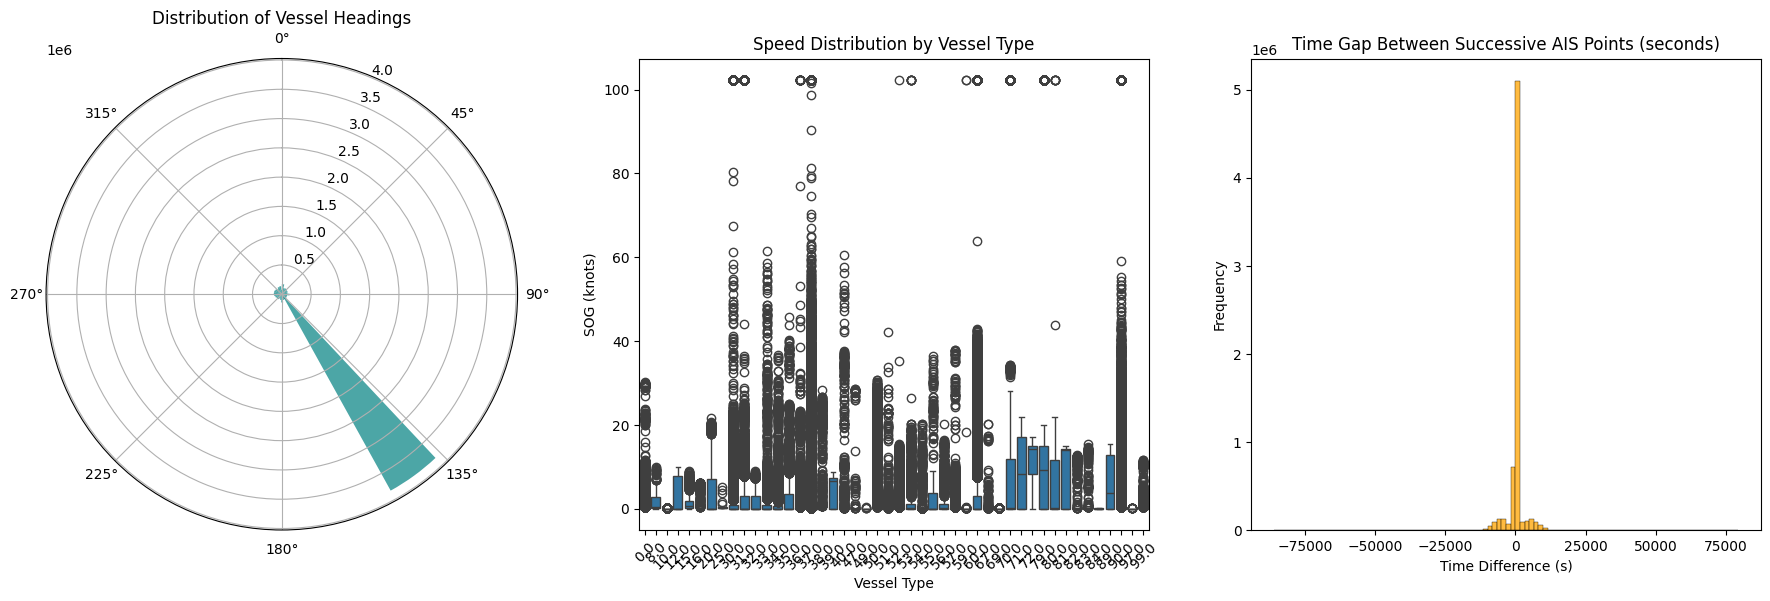

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


def plot_vessel_stats(df):
    """
    Plot vessel movement statistics:
    1. Distribution of vessel headings (polar histogram)
    2. Speed distribution by vessel type (boxplot)
    3. Time gaps between successive AIS points (histogram)
    """
    # Ensure BaseDateTime is datetime
    if not pd.api.types.is_datetime64_any_dtype(df["BaseDateTime"]):
        df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors="coerce")

    # Compute time differences between successive AIS points per MMSI
    df["time_diff"] = df.groupby("MMSI")["BaseDateTime"].diff().dt.total_seconds()

    # -------------------------------
    # Create figure with 3 subplots
    # -------------------------------
    fig = plt.figure(figsize=(18, 6))

    # 1️⃣ Polar histogram of vessel headings
    ax1 = plt.subplot(1, 3, 1, polar=True)
    headings = np.deg2rad(df["Heading"].dropna())
    ax1.hist(headings, bins=36, color="teal", alpha=0.7)
    ax1.set_theta_zero_location("N")  # 0° at the top
    ax1.set_theta_direction(-1)  # Clockwise
    ax1.set_title("Distribution of Vessel Headings")

    # 2️⃣ Boxplot of speed (SOG) by VesselType
    ax2 = plt.subplot(1, 3, 2)
    sns.boxplot(data=df, x="VesselType", y="SOG", ax=ax2)
    ax2.set_title("Speed Distribution by Vessel Type")
    ax2.set_xlabel("Vessel Type")
    ax2.set_ylabel("SOG (knots)")
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    # 3️⃣ Histogram of time differences between AIS points
    ax3 = plt.subplot(1, 3, 3)
    sns.histplot(df["time_diff"].dropna(), bins=100, ax=ax3, color="orange")
    ax3.set_title("Time Gap Between Successive AIS Points (seconds)")
    ax3.set_xlabel("Time Difference (s)")
    ax3.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


# -------------------------------
# USAGE
for name, df in ais_data.items():
    print(f"\n📊 Vessel Stats for {name}")
    plot_vessel_stats(df)

In [ ]:
ais_data["AIS_2020_01_01"]

NameError: name 'ais_data' is not defined

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import os

# Ensure output directory exists
os.makedirs("outputs/eda", exist_ok=True)

# ✅ Create GeoDataFrame of vessel positions
gdf = gpd.GeoDataFrame(
    all_data_sample,
    geometry=gpd.points_from_xy(all_data_sample.LON, all_data_sample.LAT),
    crs="EPSG:4326",
)

# ✅ Project to Web Mercator for plotting with basemaps
gdf_web = gdf.to_crs(epsg=3857)

# =========================
# OPTION A — Point Density Map
# =========================
fig, ax = plt.subplots(figsize=(12, 10))
gdf_web.plot(ax=ax, markersize=1, alpha=0.5, color="steelblue")

# ✅ Use OpenStreetMap as basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("Vessel Position Density (OpenStreetMap)", fontsize=14)
plt.savefig("outputs/eda/geopandas_points.png", dpi=300, bbox_inches="tight")
plt.show()